# Imports and setup

### Auto-re-import python modules, useful for editing local fils

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [107]:
import itertools
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    det_curve,
    f1_score,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    roc_curve,
    top_k_accuracy_score,
)

mpl.rcParams["figure.max_open_warning"] = 0

# Read in data

In [3]:
analysis_outdir = (
    "s3://seanome-kmerseek/scope-benchmark/analysis-outputs/2024-10-09__protein_k5-20"
)

In [108]:
def make_multisearch_pq(
    ksize,
    outdir,
    moltype,
):
    basename = f"scope40.multisearch.{moltype}.k{ksize}.pq"
    pq = f"{outdir}/00_cleaned_multisearch_results/{basename}"
    return pq

In [109]:
# Skip ksizes 5 and 6 for now because those files are enormous, 2.3 GiB for k=5 and 175 MiB for k=6
# -> Figure out how to use polars later
ksizes = range(7, 21)

## Explore with ksize=7

In [110]:
ksize = 7

In [111]:
pq = make_multisearch_pq(ksize, analysis_outdir, "protein")
multisearch = pd.read_parquet(pq)
print(multisearch.shape)
multisearch.head()

(53653, 27)


,query_name,query_md5,match_name,match_md5,containment,max_containment,jaccard,intersect_hashes,prob_overlap,prob_overlap_adjusted,...,query_superfamily,query_fold,query_class,match_scop_id,match_scop_lineage,match_scop_lineage_fixed,match_family,match_superfamily,match_fold,match_class
0,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,c421e5f8287a85d62fcaa1209f2e6710,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,c421e5f8287a85d62fcaa1209f2e6710,1.000000,1.000000,1.000000,74.0,1.045411e-11,0.002408,...,a.25.3,a.25,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a
1,d2ddha2 a.29.3.2 (A:475-655) Peroxisomal acyl-...,6d88fc202c6a99e85787140402556570,d4j42a_ a.25.3.0 (A:) automated matches {Bacil...,c421e5f8287a85d62fcaa1209f2e6710,0.005714,0.013514,0.004032,1.0,5.430706e-13,0.000125,...,a.29.3,a.29,a,d4j42a_,a.25.3.0,a.25.3.0,a.25.3.0,a.25.3,a.25,a
2,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,9ed04439c75190fcaa6670677b91529c,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,9ed04439c75190fcaa6670677b91529c,1.000000,1.000000,1.000000,98.0,1.452714e-11,0.003346,...,b.33.1,b.33,b,d3gcea_,b.33.1.0,b.33.1.0,b.33.1.0,b.33.1,b.33,b
3,d4q48a3 a.4.5.0 (A:408-512) automated matches ...,cbef03c9db668c5165e1332706d5a2b4,d4q48a3 a.4.5.0 (A:408-512) automated matches ...,cbef03c9db668c5165e1332706d5a2b4,1.000000,1.000000,1.000000,99.0,1.384830e-11,0.003190,...,a.4.5,a.4,a,d4q48a3,a.4.5.0,a.4.5.0,a.4.5.0,a.4.5,a.4,a
4,d2qpza_ b.33.1.0 (A:) automated matches {Pseud...,c86aa06478c835b20c65a8740e89a53e,d3gcea_ b.33.1.0 (A:) automated matches {Nocar...,9ed04439c75190fcaa6670677b91529c,0.010309,0.010309,0.005155,1.0,5.430706e-13,0.000125,...,b.33.1,b.33,b,d3gcea_,b.33.1.0,b.33.1.0,b.33.1.0,b.33.1,b.33,b


In [112]:
lineage_cols = ["family", "superfamily", "fold", "class"]

for lineage_col in lineage_cols:
    query = f"query_{lineage_col}"
    match = f"match_{lineage_col}"

    multisearch[lineage_col] = multisearch[query] == multisearch[match]

# Ignore self matches
print(f"Before removing self-matches: {multisearch.shape}")
multisearch_no_self = multisearch.query("query_name != match_name")
print(f"After  removing self-matches: {multisearch_no_self.shape}")

Before removing self-matches: (53653, 31)
After  removing self-matches: (38476, 31)


In [113]:
lineage_nunique = multisearch[
    ["query_family", "query_superfamily", "query_fold", "query_class"]
].value_counts()
lineage_nunique

query_family  query_superfamily  query_fold  query_class
c.2.1.0       c.2.1              c.2         c              2308
d.144.1.0     d.144.1            d.144       d               939
c.2.1.2       c.2.1              c.2         c               840
c.67.1.0      c.67.1             c.67        c               773
c.37.1.0      c.37.1             c.37        c               766
                                                            ... 
g.95.1.1      g.95.1             g.95        g                 1
g.55.1.1      g.55.1             g.55        g                 1
g.58.1.1      g.58.1             g.58        g                 1
g.59.1.0      g.59.1             g.59        g                 1
g.6.1.1       g.6.1              g.6         g                 1
Name: count, Length: 4708, dtype: int64

In [114]:
multisearch_no_self[lineage_cols].sum()

family          7316
superfamily    12482
fold           12720
class          20644
dtype: int64

## Explore with "class"

In [115]:
lineage_col = "class"

In [116]:
lineage_class_value_counts = multisearch["query_class"].value_counts()
lineage_class_value_counts

query_class
c    23474
d    11009
a     7735
b     7633
e     1776
f     1073
g      953
Name: count, dtype: int64

In [117]:
# def get_percentage_found(

multisearch_no_self.groupby("query_class").apply(
    lambda x: x["class"].sum() / lineage_class_value_counts[x.name]
)

/tmp/ipykernel_11181/4068619271.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multisearch_no_self.groupby("query_class").apply(


query_class
a    0.228571
b    0.248133
c    0.553463
d    0.302843
e    0.239865
f    0.139795
g    0.083945
dtype: float64

In [118]:
multisearch_no_self["class"].value_counts()

class
True     20644
False    17832
Name: count, dtype: int64

### Show Example Classification Report

In [122]:
y_true = multisearch_no_self["query_class"]
y_pred = multisearch_no_self["match_class"]
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
    precision_recall_fscore_support,
)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       0.35      0.35      0.35      5091
           b       0.41      0.41      0.41      4574
           c       0.68      0.68      0.68     19011
           d       0.45      0.45      0.45      7356
           e       0.29      0.29      0.29      1472
           f       0.20      0.20      0.20       741
           g       0.35      0.35      0.35       231

    accuracy                           0.54     38476
   macro avg       0.39      0.39      0.39     38476
weighted avg       0.54      0.54      0.54     38476



(array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([0.34727951, 0.41407958, 0.68339382, 0.45323545, 0.28940217,
        0.20242915, 0.34632035]),
 array([ 5091,  4574, 19011,  7356,  1472,   741,   231]))

In [120]:
classification_report??

Signature:
classification_report(
    y_true,
    y_pred,
    *,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division='warn',
)
Source:   
@validate_params(
    {
        "y_true": ["array-like", "sparse matrix"],
        "y_pred": ["array-like", "sparse matrix"],
        "labels": ["array-like", None],
        "target_names": ["array-like", None],
        "sample_weight": ["array-like", None],
        "digits": [Interval(Integral, 0, None, closed="left")],
        "output_dict": ["boolean"],
        "zero_division": [
            Options(Real, {0.0, 1.0}),
            "nan",
            StrOptions({"warn"}),
        ],
    },
    prefer_skip_nested_validation=True,
)
def classification_report(
    y_true,
    y_pred,
    *,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
):
    """Build a text report showing the main classification metrics.



In [17]:
precision, recall, thresholds = precision_recall_curve(
    multisearch_no_self["class"], multisearch_no_self.containment
)

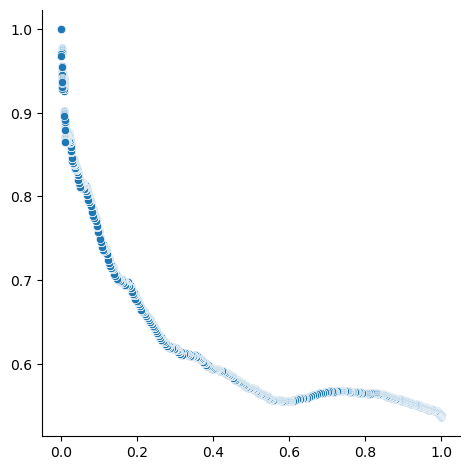

In [18]:
sns.relplot(x=recall, y=precision)

### PrecisionRecallDisplay

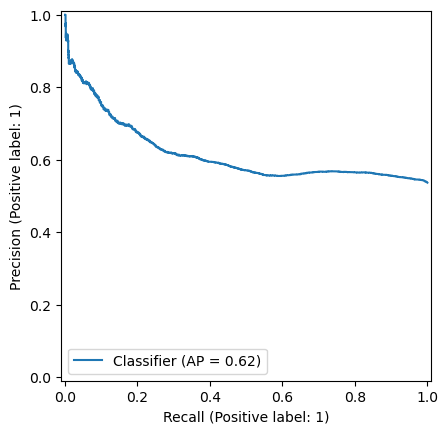

In [19]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

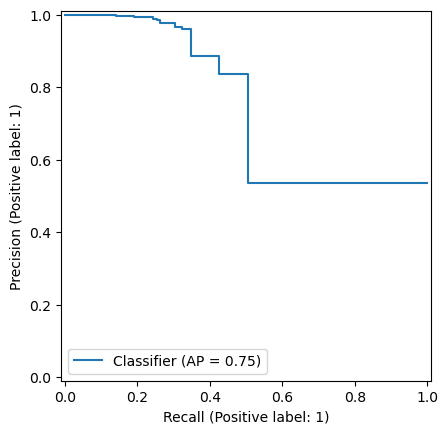

In [20]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.prob_overlap_adjusted
)

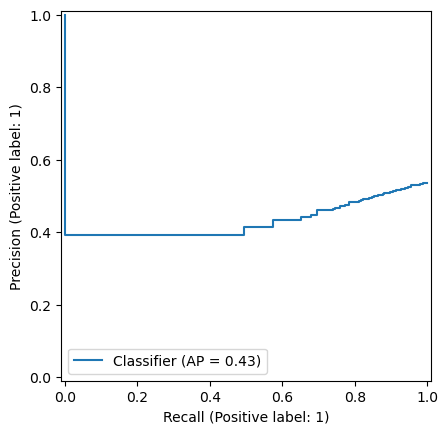

In [21]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], 1 / multisearch_no_self.prob_overlap_adjusted
)

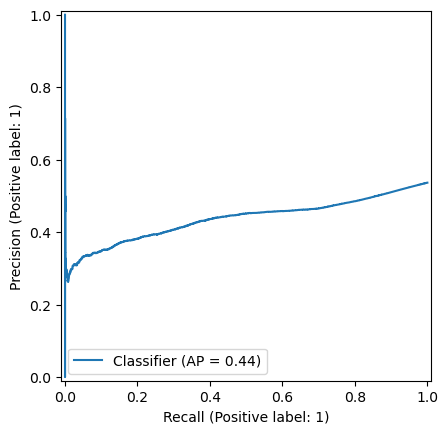

In [22]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

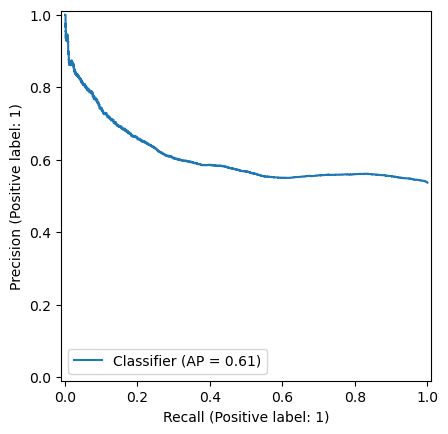

In [23]:
PrecisionRecallDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

### RocCurveDisplay

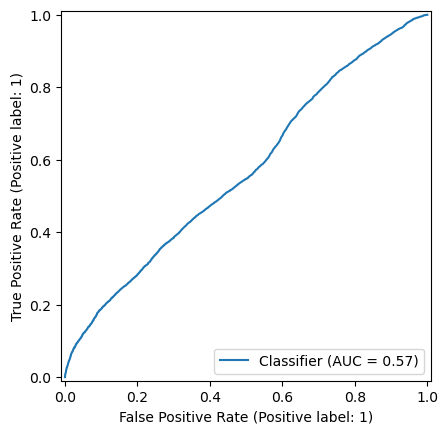

In [24]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

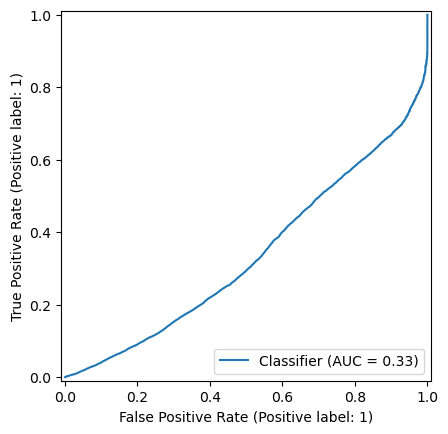

In [25]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

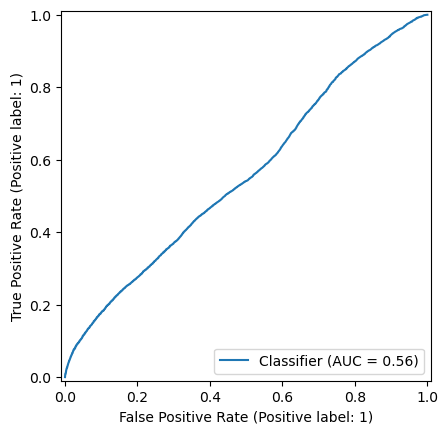

In [26]:
RocCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

### DetCurveDisplay

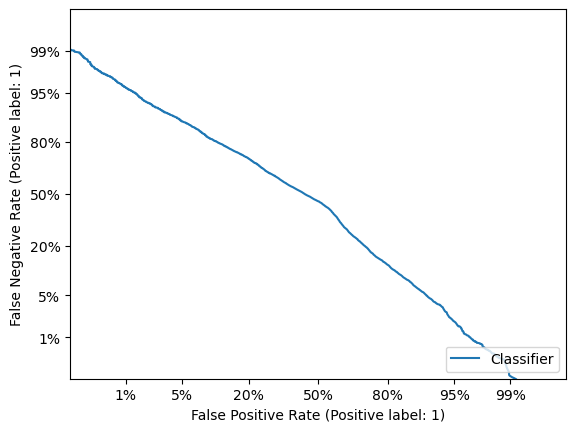

In [27]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment
)

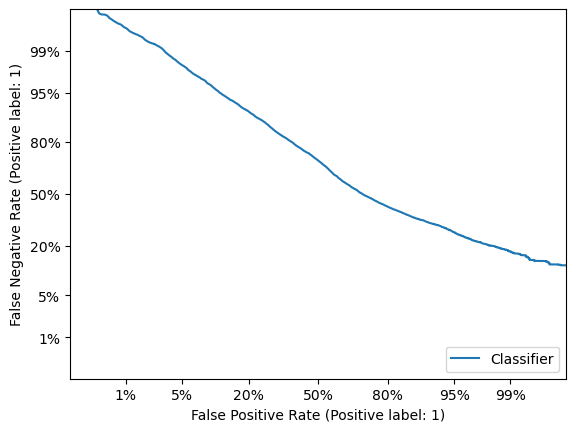

In [28]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.containment_adjusted_log10
)

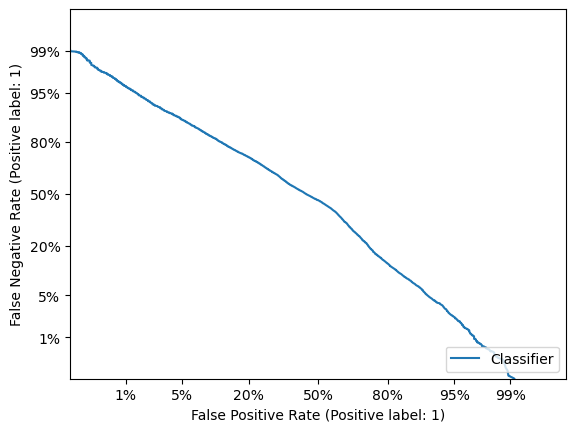

In [29]:
DetCurveDisplay.from_predictions(
    multisearch_no_self["class"], multisearch_no_self.tf_idf_score
)

## Compute precision-recall, ROC, DET curves

In [56]:
from typing import Literal

score_cols = (
    "containment",
    "tf_idf_score",
    "containment_adjusted_log10",
    "prob_overlap_adjusted",
)

dfs = []


def make_precision_recall_curve_df(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    # Add a dummy value to thresholds so all the arrays are the same length
    thresholds = np.concat([thresholds, [thresholds.max()]])
    df = pd.DataFrame(dict(precision=precision, recall=recall, thresholds=thresholds))
    return df


def make_roc_curve_df(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr, thresholds=thresholds))
    return df


def make_det_curve_df(y_true, y_score):
    fpr, fnr, thresholds = det_curve(y_true, y_score)
    df = pd.DataFrame(dict(fpr=fpr, fnr=fnr, thresholds=thresholds))
    return df


curve_df_makers = {
    "precision_recall": make_precision_recall_curve_df,
    "roc": make_roc_curve_df,
    "det": make_det_curve_df,
}


def make_curve_df(
    y_true,
    y_score,
    lineage,
    score_name,
    curve: Literal["precision_recall", "roc", "det"],
):
    df_maker = curve_df_makers[curve]
    df = df_maker(y_true, y_score)
    df["lineage"] = lineage_col
    df["score_name"] = score_col
    return df


curve_dfs = {
    "precision_recall": [],
    "roc": [],
    "det": [],
}

lines = []


for lineage_col in lineage_cols:
    for score_col in score_cols:
        y_true = multisearch_no_self[lineage_col]
        # y_true = multisearch_no_self[lineage_col]
        y_score = multisearch_no_self[score_col]

        ap_score = average_precision_score(y_true, y_score)
        roc_score = roc_auc_score(y_true, y_score)

        lines.append([lineage_col, score_col, ap_score, "average_precision"])
        lines.append([lineage_col, score_col, roc_score, "roc"])

        for curve in curve_df_makers.keys():
            df = make_curve_df(y_true, y_score, lineage_col, score_col, curve)

            curve_dfs[curve].append(df)
classification_metrics = pd.DataFrame(
    lines, columns=["lineage", "sourmash_score", "metric", "metric_name"]
)
classification_metrics

,lineage,sourmash_score,metric,metric_name
0,family,containment,0.311685,average_precision
1,family,containment,0.631559,roc
2,family,tf_idf_score,0.303030,average_precision
3,family,tf_idf_score,0.618050,roc
4,family,containment_adjusted_log10,0.132928,average_precision
5,family,containment_adjusted_log10,0.300670,roc
6,family,prob_overlap_adjusted,0.459467,average_precision
7,family,prob_overlap_adjusted,0.787603,roc
8,superfamily,containment,0.507712,average_precision
9,superfamily,containment,0.652650,roc


### Show Example Classification Report

In [102]:
y_true = multisearch_no_self["query_class"]
y_pred = multisearch_no_self["match_class"]
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00        10
           b       1.00      1.00      1.00         8
           c       1.00      1.00      1.00         8
           d       1.00      1.00      1.00         2
           e       1.00      1.00      1.00         2
           g       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



### Show Confusion Matrix

In [103]:
confusion_matrix(y_true, y_pred)

array([[10,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  2]])

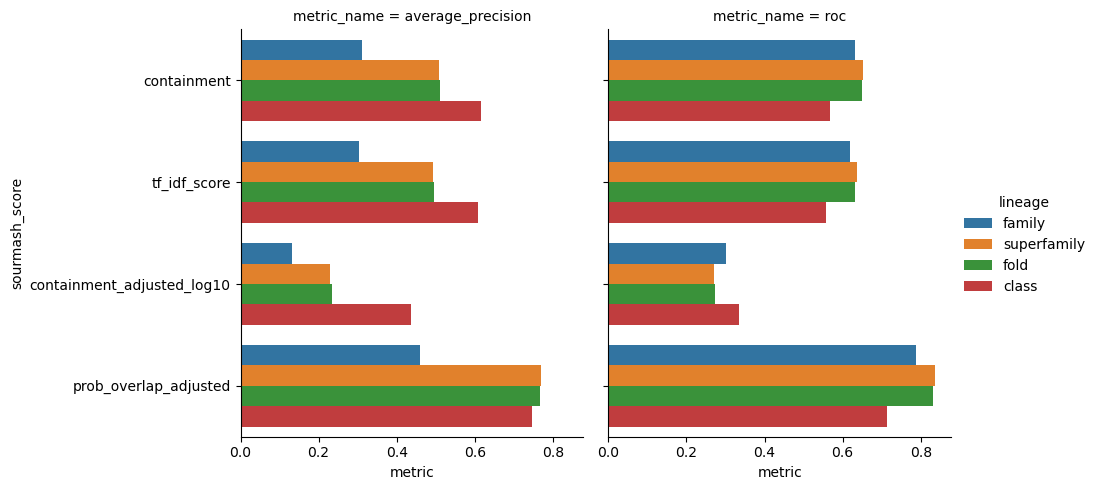

In [66]:
sns.catplot(
    data=classification_metrics,
    x="metric",
    hue="lineage",
    y="sourmash_score",
    col="metric_name",
    kind="bar",
    # palette="Set2",
)

In [41]:
len(curve_dfs["precision_recall"])

16

In [42]:
precision_recall_df = pd.concat(curve_dfs["precision_recall"])
print(precision_recall_df.shape)
precision_recall_df.head()

(45524, 5)


,precision,recall,thresholds,lineage,score_name
0,0.190145,1.000000,0.000603,family,containment
1,0.190188,0.999863,0.000669,family,containment
2,0.190290,0.999727,0.000693,family,containment
3,0.190350,0.999727,0.000795,family,containment
4,0.190370,0.999727,0.000833,family,containment


In [43]:
det_df = pd.concat(curve_dfs["det"])
print(det_df.shape)
det_df.head()

(44706, 5)


,fpr,fnr,thresholds,lineage,score_name
0,1.000000,0.000000,0.000603,family,containment
1,0.999583,0.000137,0.000669,family,containment
2,0.998780,0.000273,0.000693,family,containment
3,0.998395,0.000273,0.000795,family,containment
4,0.998267,0.000273,0.000833,family,containment


In [44]:
roc_df = pd.concat(curve_dfs["roc"])
print(roc_df.shape)
roc_df.head()

(35302, 5)


,fpr,tpr,thresholds,lineage,score_name
0,0.000000,0.000000,inf,family,containment
1,0.000064,0.000410,1.000000,family,containment
2,0.000064,0.000683,0.833333,family,containment
3,0.000096,0.000683,0.818182,family,containment
4,0.000096,0.001914,0.170543,family,containment


## Plot curves across SCOP lineages and sourmash match scores (containment, tf-idf score, adjusted containment, probability of overlap)

### Plot Precision Recall

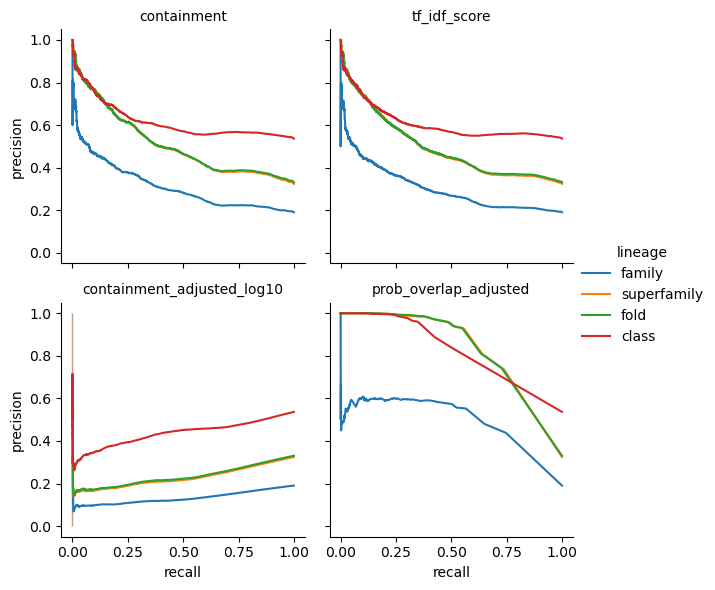

In [68]:
g = sns.relplot(
    data=precision_recall_df,
    x="recall",
    y="precision",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

### Plot ROC AUC

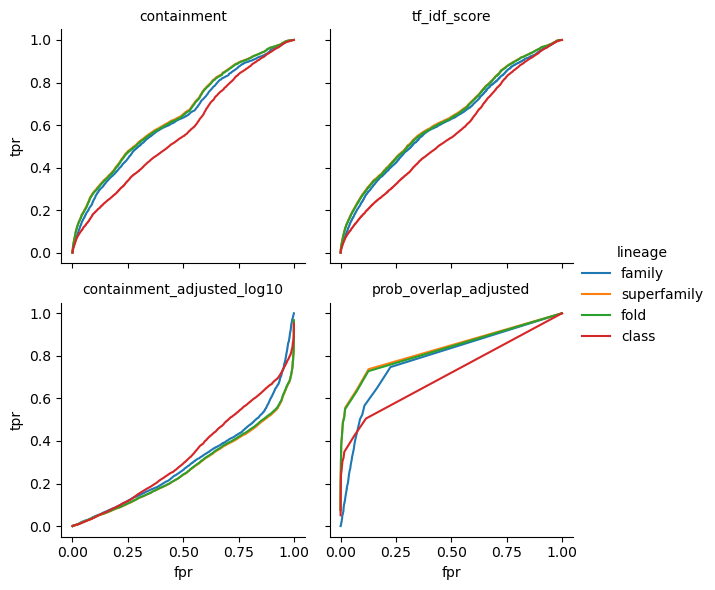

In [50]:
g = sns.relplot(
    data=roc_df,
    x="fpr",
    y="tpr",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

### Plot DET Curve

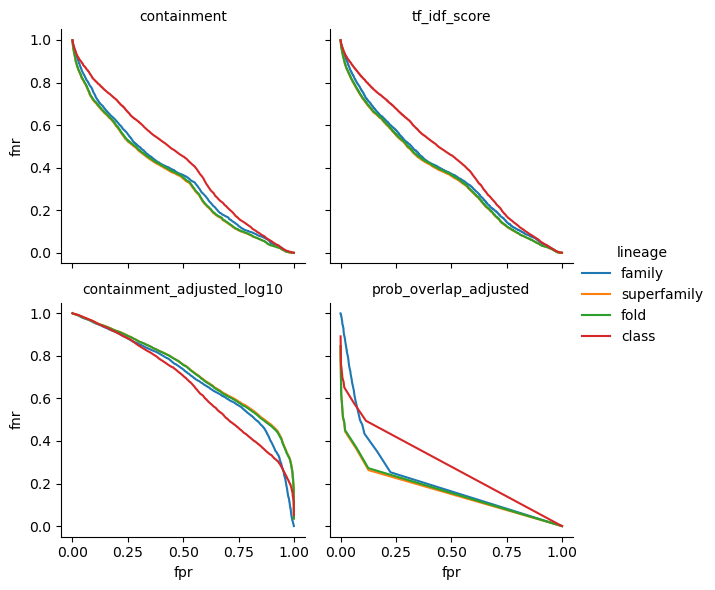

In [67]:
g = sns.relplot(
    data=det_df,
    x="fpr",
    y="fnr",
    hue="lineage",
    col="score_name",
    height=3,
    col_wrap=2,
    kind="line",
)
g.set_titles("{col_name}")

# Compute metrics across all ksizes

In [ ]:
curve_dfs = {
    "precision_recall": [],
    "roc": [],
    "det": [],
}

lines = []


def make_curve_df_ksize_moltype(
    y_true,
    y_score,
    lineage,
    sourmash_score,
    curve: Literal["precision_recall", "roc", "det"],
    ksize: int,
    moltype: Literal["protein", "dayhoff", "hp"],
):
    df_maker = curve_df_makers[curve]
    df = df_maker(y_true, y_score)
    df["lineage"] = lineage_col
    df["sourmash_score"] = score_col
    df["moltype"] = moltype
    df["ksize"] = ksize
    return df


moltype = "protein"


binary_classification_scorers = {
    "average_precision": average_precision_score,
    "roc_auc": roc_auc_score,
    # "top_k_accuracy": top_k_accuracy_score,
}

multiclass_scorers = {
    "recall": lambda x, y: recall_score(x, y, average="macro"),
    "f1": lambda x, y: f1_score(x, y, average='macro'),
    "balanced_accuracy": balanced_accuracy_score,
    "accuracy": accuracy_score,
    # "top_k_accuracy": top_k_accuracy_score,
}

confusion_matrices = {}


def make_score_line(
    y_true, y_pred, sklearn_score_name, lineage, sourmash_score_name, ksize, moltype
):
    try:
        scorer = binary_classification_scorers[sklearn_score_name]
    except KeyError:
        scorer = multiclass_scorers[sklearn_score_name]
    score_value = scorer(y_true, y_pred)
    line = [
        moltype,
        ksize,
        lineage,
        sourmash_score_name,
        score_value,
        sklearn_score_name,
    ]
    return line


def make_precision_recall_fscore_support_df(
    y_true, y_pred, lineage, sourmash_score_name, ksize, moltype
):
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average="macro")

    df = pd.DataFrame(dict(precision=p, recall=r, fscore=f, support=s))
    df["lineage"] = lineage
    df["sourmash_score"] = sourmash_score_name
    df["moltype"] = moltype
    df["ksize"] = ksize
    return df


lines = []
ksizes = range(7, 21)
for ksize in ksizes:
    print(f"--- ksize: {ksize} ---")
    pq = make_multisearch_pq(ksize, analysis_outdir, "protein")
    multisearch = pd.read_parquet(pq)

    lineage_cols = ["family", "superfamily", "fold", "class"]

    for lineage_col in lineage_cols:
        query = f"query_{lineage_col}"
        match = f"match_{lineage_col}"

        multisearch[lineage_col] = multisearch[query] == multisearch[match]

    # Ignore self matches
    print(f"Before removing self-matches: {multisearch.shape}")
    multisearch_no_self = multisearch.query("query_name != match_name")
    print(f"After  removing self-matches: {multisearch_no_self.shape}")

    for lineage_col in lineage_cols:
        for sourmash_score_name in score_cols:
            y_true_bool = multisearch_no_self[lineage_col]

            y_true = multisearch_no_self[f"query_{lineage_col}"]
            y_pred = multisearch_no_self[f"match_{lineage_col}"]
            y_score = multisearch_no_self[sourmash_score_name]

            for sklearn_score in binary_classification_scorers.keys():
                try:
                    line = make_score_line(
                        y_true_bool,
                        y_score,
                        sklearn_score,
                        lineage_col,
                        sourmash_score_name,
                        ksize,
                        moltype,
                    )
                    lines.append(line)
                except ValueError:
                    # skip when ROC isn't defined, when only one class is present
                    pass

            for sklearn_score in multiclass_scorers.keys():
                # try:
                line = make_score_line(
                    y_true,
                    y_pred,
                    sklearn_score,
                    lineage_col,
                    sourmash_score_name,
                    ksize,
                    moltype,
                )
                lines.append(line)
                # except ValueError:
                #     # skip when ROC isn't defined, when only one class is present
                #     pass

            matrix = confusion_matrix(y_true, y_pred)
            key = (moltype, ksize, sourmash_score_name, lineage_col)
            confusion_matrices[key] = matrix

            for curve in curve_df_makers.keys():
                try:
                    with warnings.catch_warnings(action="ignore"):
                        # Ignore warnings that show up only one class in y_true
                        # UndefinedMetricWarning: No negative samples in y_true,
                        # false positive value should be meaningless
                        df = make_curve_df_ksize_moltype(
                            y_true_bool,
                            y_score,
                            lineage_col,
                            sourmash_score_name,
                            curve,
                            ksize,
                            moltype,
                        )

                        curve_dfs[curve].append(df)
                except ValueError:
                    # skip when ROC or DET aren't defined, when only one class is present
                    pass

classification_metrics = pd.DataFrame(
    lines,
    columns=["moltype", "ksize", "lineage", "sourmash_score", "metric", "metric_name"],
)
classification_metrics

--- ksize: 7 ---
Before removing self-matches: (53653, 31)
After  removing self-matches: (38476, 31)
--- ksize: 8 ---
Before removing self-matches: (22843, 31)
After  removing self-matches: (7666, 31)
--- ksize: 9 ---
Before removing self-matches: (18273, 31)
After  removing self-matches: (3096, 31)
--- ksize: 10 ---
Before removing self-matches: (16725, 31)
After  removing self-matches: (1548, 31)
--- ksize: 11 ---
Before removing self-matches: (16001, 31)
After  removing self-matches: (824, 31)
--- ksize: 12 ---
Before removing self-matches: (15621, 31)
After  removing self-matches: (444, 31)
--- ksize: 13 ---
Before removing self-matches: (15439, 31)
After  removing self-matches: (262, 31)
--- ksize: 14 ---
Before removing self-matches: (15347, 31)
After  removing self-matches: (170, 31)
--- ksize: 15 ---
Before removing self-matches: (15279, 31)
After  removing self-matches: (102, 31)
--- ksize: 16 ---


In [131]:
classification_metrics.metric_name.value_counts()

metric_name
average_precision    224
balanced_accuracy    224
accuracy             224
roc_auc              188
Name: count, dtype: int64

In [132]:
classification_metrics

,moltype,ksize,lineage,sourmash_score,metric,metric_name
0,protein,7,family,containment,0.311685,average_precision
1,protein,7,family,containment,0.631559,roc_auc
2,protein,7,family,containment,0.049119,balanced_accuracy
3,protein,7,family,containment,0.190145,accuracy
4,protein,7,family,tf_idf_score,0.303030,average_precision
...,...,...,...,...,...,...
855,protein,20,class,containment_adjusted_log10,1.000000,balanced_accuracy
856,protein,20,class,containment_adjusted_log10,1.000000,accuracy
857,protein,20,class,prob_overlap_adjusted,1.000000,average_precision
858,protein,20,class,prob_overlap_adjusted,1.000000,balanced_accuracy


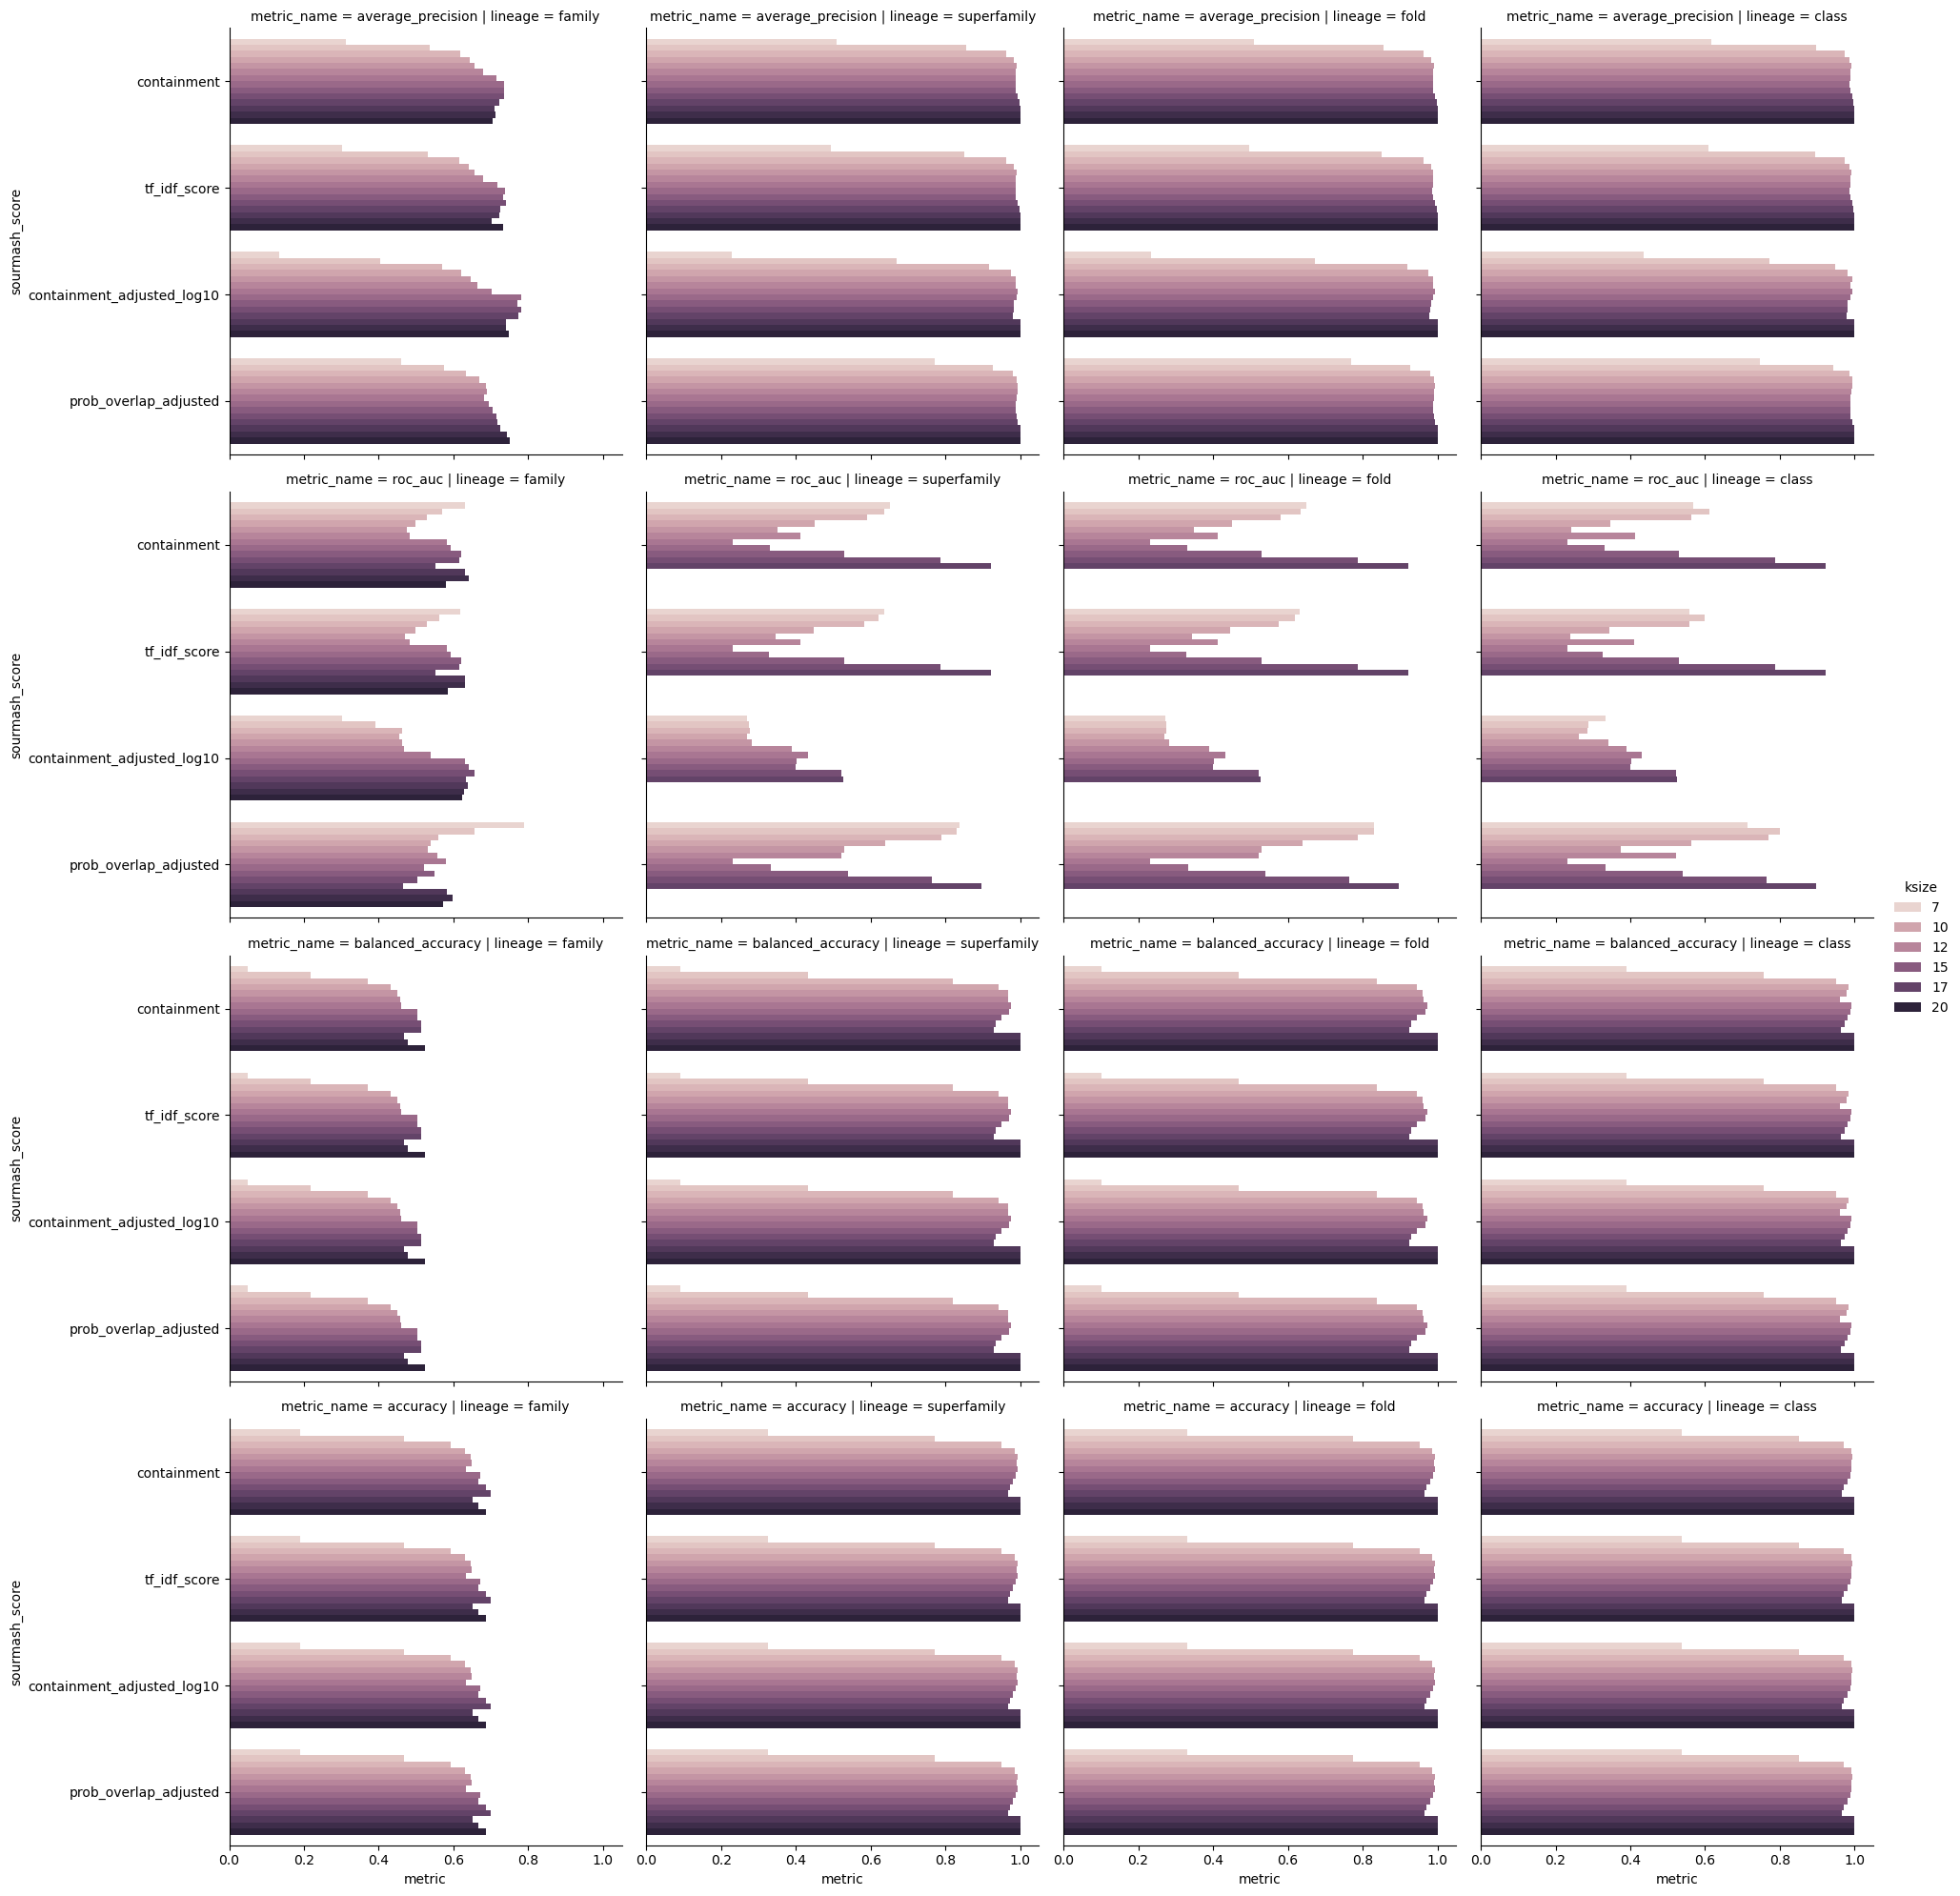

In [133]:
sns.catplot(
    data=classification_metrics,
    x="metric",
    hue="ksize",
    y="sourmash_score",
    col="lineage",
    row="metric_name",
    kind="bar",
    # palette="Set2",
)